In [1]:
import pandas as pd

file_paths = {
    'English': "./data/20242026_outlook_n21_en_250117.xlsx",
    'French': "./data/20242026_outlook_n21_fr_250117.xlsx"
}

# Open the English xlsx file
english_df = pd.read_excel(file_paths['English'])

In [4]:
sorted_df = english_df.sort_values(by=['NOC Title', 'Economic Region Name'])

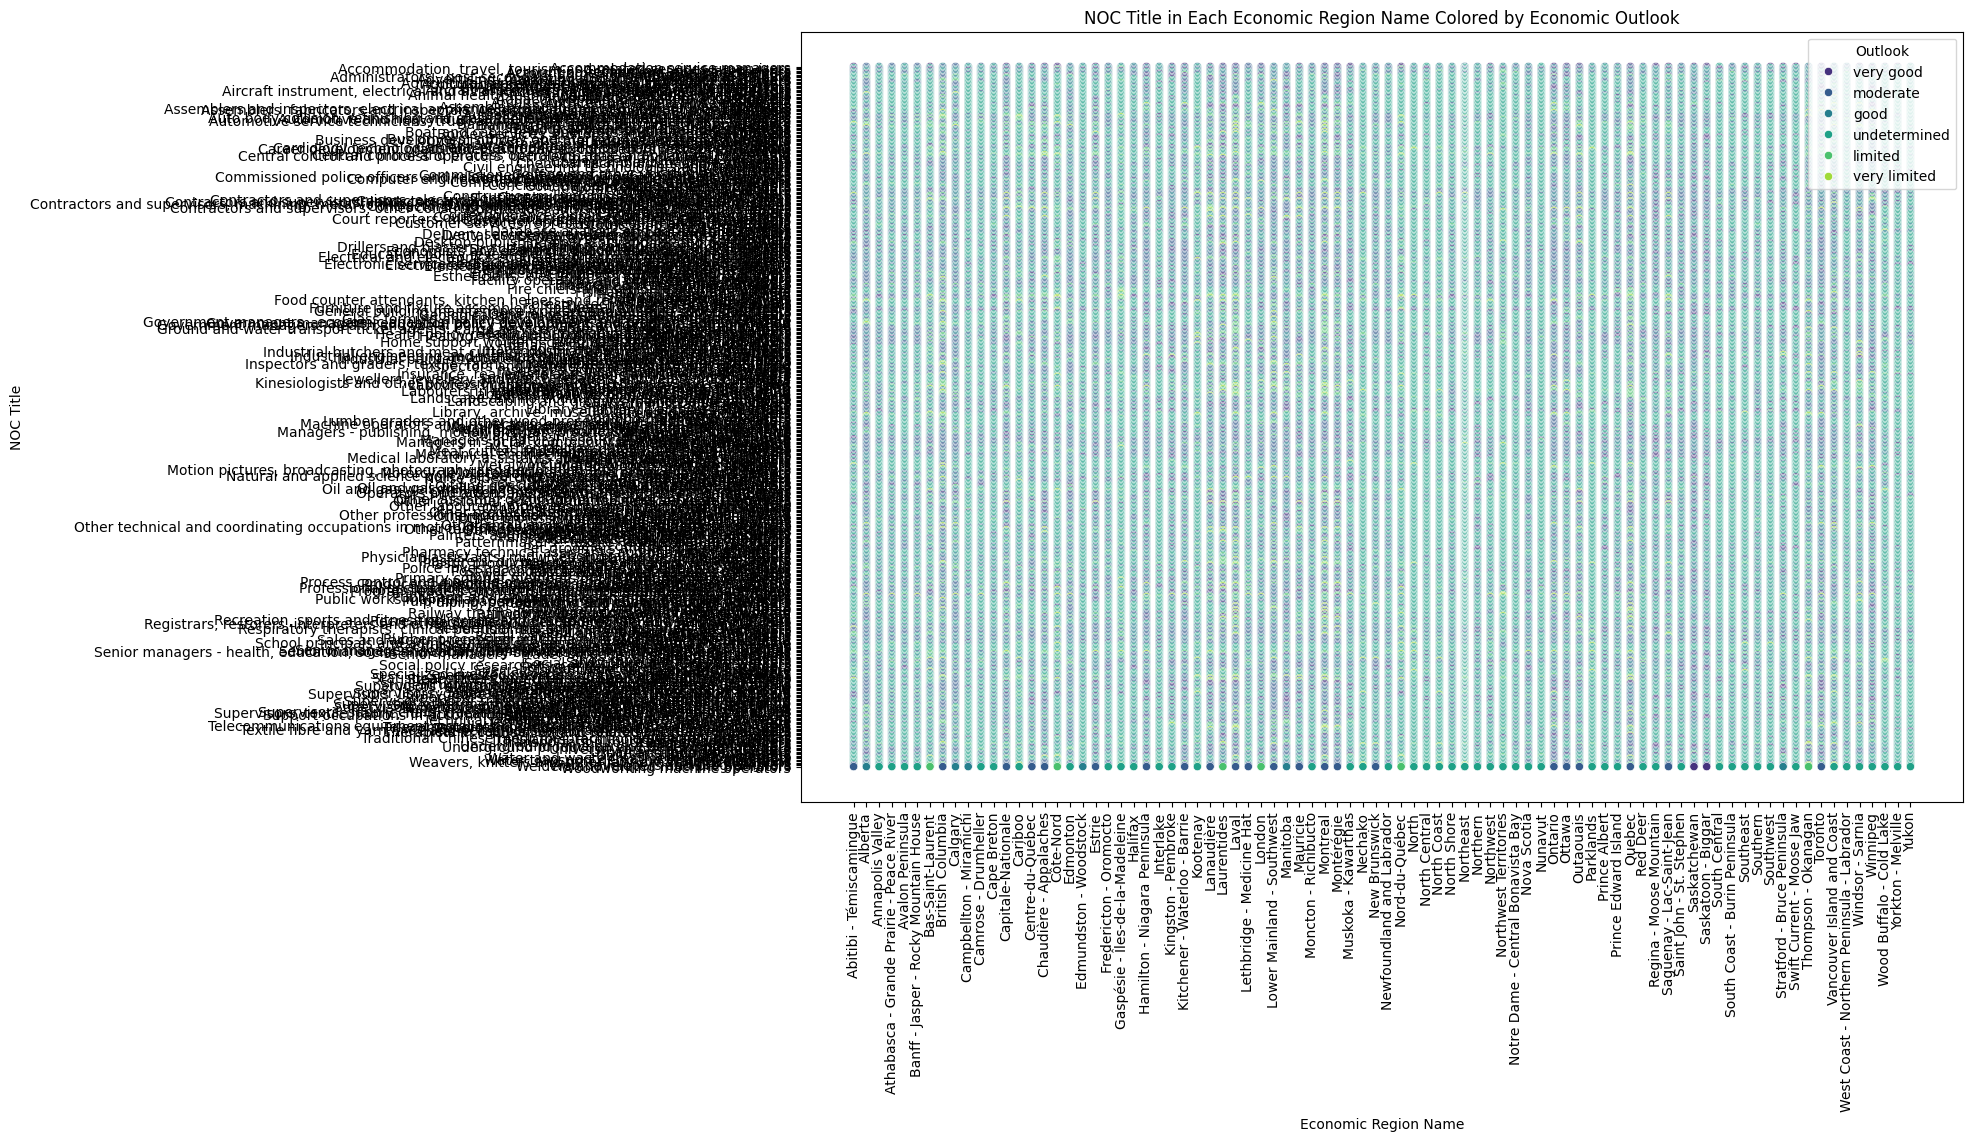

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size
plt.figure(figsize=(15, 10))

# Create a scatter plot
sns.scatterplot(data=sorted_df, x='Economic Region Name', y='NOC Title', hue='Outlook', palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('NOC Title in Each Economic Region Name Colored by Economic Outlook')
plt.xlabel('Economic Region Name')
plt.ylabel('NOC Title')

# Show the plot
plt.show()

# Dash version thats better!

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load the Excel file
file_paths = {
    'English': "./data/20242026_outlook_n21_en_250117.xlsx",
    'French': "./data/20242026_outlook_n21_fr_250117.xlsx"
}

# Open the English xlsx file
english_df = pd.read_excel(file_paths['English'])

# Sort the DataFrame
sorted_df = english_df.sort_values(by=['NOC Title', 'Economic Region Name'])

# Initialize the Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Dropdown(
        id='noc-dropdown',
        options=[{'label': title, 'value': title} for title in sorted_df['NOC Title'].unique()],
        value=sorted_df['NOC Title'].iloc[0],
        clearable=False
    ),
    dcc.Graph(id='scatter-plot')
])

# Callback to update the scatter plot based on dropdown selection
@app.callback(
    Output('scatter-plot', 'figure'),
    Input('noc-dropdown', 'value')
)
def update_scatter(selected_noc):
    filtered_df = sorted_df[sorted_df['NOC Title'] == selected_noc]
    
    fig = px.scatter(
        filtered_df, x='Economic Region Name', y='NOC Title', color='Outlook',
        title='NOC Title in Each Economic Region Name Colored by Economic Outlook',
        color_continuous_scale='viridis'
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import geopandas as gpd

# Load the Excel file
file_paths = {
    'English': "./data/20242026_outlook_n21_en_250117.xlsx",
    'French': "./data/20242026_outlook_n21_fr_250117.xlsx"
}

# Open the English xlsx file
english_df = pd.read_excel(file_paths['English'])

# Define the custom order and color scale for the 'Outlook' column
outlook_order = ['very good', 'good', 'moderate', 'limited', 'undetermined']
outlook_colors = {
    'very good': 'green',
    'good': 'blue',
    'moderate': 'yellow',
    'limited': 'orange',
    'undetermined': 'red'
}

# Sort the DataFrame based on the custom order
english_df['Outlook'] = pd.Categorical(english_df['Outlook'], categories=outlook_order, ordered=True)
sorted_df = english_df.sort_values(by=['NOC Title', 'Economic Region Name', 'Outlook'])

# Load the shapefile
gdf = gpd.read_file("./data/ler_000b16a_e.shp")
gdf = gdf.to_crs(epsg=4326)  # Ensure the coordinate reference system is WGS84

# Simplify geometries to improve performance
gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.01, preserve_topology=True)

# Calculate centroids for each region
gdf['centroid'] = gdf.geometry.centroid

# Merge the job outlook data with the shapefile
merged_df = gdf[['ERNAME', 'centroid']].merge(sorted_df, left_on='ERNAME', right_on='Economic Region Name')

# Extract latitude and longitude from centroids
merged_df['lat'] = merged_df['centroid'].apply(lambda point: point.y)
merged_df['lon'] = merged_df['centroid'].apply(lambda point: point.x)

# Initialize the Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Dropdown(
        id='noc-dropdown',
        options=[{'label': title, 'value': title} for title in sorted_df['NOC Title'].unique()],
        value=[sorted_df['NOC Title'].iloc[0]],  # Default value
        multi=True,  # Allow multiple selections
        clearable=False
    ),
    dcc.Graph(id='map-plot')
])

# Callback to update the map plot based on dropdown selection
@app.callback(
    Output('map-plot', 'figure'),
    Input('noc-dropdown', 'value')
)
def update_map(selected_nocs):
    filtered_df = merged_df[merged_df['NOC Title'].isin(selected_nocs)]
    
    fig = px.scatter_mapbox(
        filtered_df, lat='lat', lon='lon', color='Outlook', size_max=15, zoom=3,
        mapbox_style="carto-positron", center={"lat": 56.1304, "lon": -106.3468},
        title='Career Outlook for Canadian Economic Regions 2024-2026',
        category_orders={'Outlook': outlook_order},
        color_discrete_map=outlook_colors,
        hover_name='Economic Region Name'
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)